STAT 453: Deep Learning (Spring 2020)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2020/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss20

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.7.3
IPython 7.9.0

torch 1.4.0


# LeNet-5 CIFAR10 Classifier

This notebook implements the classic LeNet-5 convolutional network [1] and applies it to the CIFAR10 object classification dataset. The basic architecture is shown in the figure below:

![](lenet-5_1.jpg)



LeNet-5 is commonly regarded as the pioneer of convolutional neural networks, consisting of a very simple architecture (by modern standards). In total, LeNet-5 consists of only 7 layers. 3 out of these 7 layers are convolutional layers (C1, C3, C5), which are connected by two average pooling layers (S2 & S4). The penultimate layer is a fully connexted layer (F6), which is followed by the final output layer. The additional details are summarized below:

- All convolutional layers use 5x5 kernels with stride 1.
- The two average pooling (subsampling) layers are 2x2 pixels wide with stride 1.
- Throughrout the network, tanh sigmoid activation functions are used. (**In this notebook, we replace these with ReLU activations**)
- The output layer uses 10 custom Euclidean Radial Basis Function neurons for the output layer. (**In this notebook, we replace these with softmax activations**)

**Please note that the original architecture was applied to MNIST-like grayscale images (1 color channel). CIFAR10 has 3 color-channels. I found that using the regular architecture results in very poor performance on CIFAR10 (approx. 50% ACC). Hence, I am multiplying the number of kernels by a factor of 3 (according to the 3 color channels) in each layer, which improves is a little bit (approx. 60% Acc).**

### References

- [1] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, november 1998.

## Imports

In [2]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

In [3]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 32*32
NUM_CLASSES = 10

# Other
if torch.cuda.is_available():
    DEVICE = "cuda:0"
else:
    DEVICE = "cpu"

GRAYSCALE = False

### MNIST Dataset

In [4]:
##########################
### CIFAR-10 Dataset
##########################

train_mean = (0.5, 0.5, 0.5)
train_std = (0.5, 0.5, 0.5)

resize_transform = transforms.Compose([transforms.Resize((32, 32)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(train_mean, train_std)])

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=resize_transform,
                                 download=True)

test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=resize_transform)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=8,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=8,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Extracting data/cifar-10-python.tar.gz to data
Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])
Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])


In [5]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


In [6]:
##########################
### MODEL
##########################


class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(
            
            nn.Conv2d(in_channels, 6*in_channels, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6*in_channels, 16*in_channels, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5*in_channels, 120*in_channels),
            nn.Tanh(),
            nn.Linear(120*in_channels, 84*in_channels),
            nn.Tanh(),
            nn.Linear(84*in_channels, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [7]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES, GRAYSCALE)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [8]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/0391 | Cost: 2.3064
Epoch: 001/010 | Batch 0050/0391 | Cost: 1.8993
Epoch: 001/010 | Batch 0100/0391 | Cost: 1.5227
Epoch: 001/010 | Batch 0150/0391 | Cost: 1.4642
Epoch: 001/010 | Batch 0200/0391 | Cost: 1.2933
Epoch: 001/010 | Batch 0250/0391 | Cost: 1.2849
Epoch: 001/010 | Batch 0300/0391 | Cost: 1.3062
Epoch: 001/010 | Batch 0350/0391 | Cost: 1.2672
Epoch: 001/010 | Train: 58.880%
Time elapsed: 0.07 min
Epoch: 002/010 | Batch 0000/0391 | Cost: 1.2770
Epoch: 002/010 | Batch 0050/0391 | Cost: 1.1695
Epoch: 002/010 | Batch 0100/0391 | Cost: 1.1555
Epoch: 002/010 | Batch 0150/0391 | Cost: 1.1715
Epoch: 002/010 | Batch 0200/0391 | Cost: 1.1600
Epoch: 002/010 | Batch 0250/0391 | Cost: 1.2648
Epoch: 002/010 | Batch 0300/0391 | Cost: 1.0766
Epoch: 002/010 | Batch 0350/0391 | Cost: 1.0279
Epoch: 002/010 | Train: 63.742%
Time elapsed: 0.14 min
Epoch: 003/010 | Batch 0000/0391 | Cost: 0.9999
Epoch: 003/010 | Batch 0050/0391 | Cost: 1.1050
Epoch: 003/010 | Batch 010

## Evaluation

In [9]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 66.11%


In [10]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Parameters:
        ------------
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        
        Returns:
        ------------
        Tensor: Normalized image.

        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
    
unorm = UnNormalize(mean=train_mean, std=train_std)

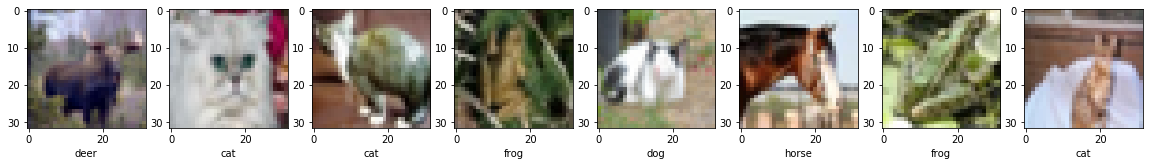

In [11]:
test_loader = DataLoader(dataset=train_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

for features, targets in test_loader:
    break
    

_, predictions = model.forward(features[:8].to(DEVICE))
predictions = torch.argmax(predictions, dim=1)

d = {0: 'airplane',
     1: 'automobile',
     2: 'bird',
     3: 'cat',
     4: 'deer',
     5: 'dog',
     6: 'frog',
     7: 'horse',
     8: 'ship',
     9: 'truck'}
    
fig, ax = plt.subplots(1, 8, figsize=(20, 10))
for i in range(8):
    img = unorm(features[i])
    ax[i].imshow(np.transpose(img, (1, 2, 0)))
    ax[i].set_xlabel(d[predictions[i].item()])

plt.show()